In [ ]:
pip install pyod

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from pyod.models.ecod import ECOD
from pyod.models.ecod import ECOD
from pyod.models.ecod import ECOD
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
data = pd.read_csv("onlinefraud.csv")
print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [ ]:
# number of rows and columns
data.shape

(6362620, 11)

In [ ]:
# Now, let’s have a look at whether this dataset has any null values or not

print(data.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
print(data.type.value_counts())

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [ ]:
CrosstabResult=pd.crosstab(index=data.type,columns=data.isFraud)
CrosstabResult

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


(3500.0, 7000.0)

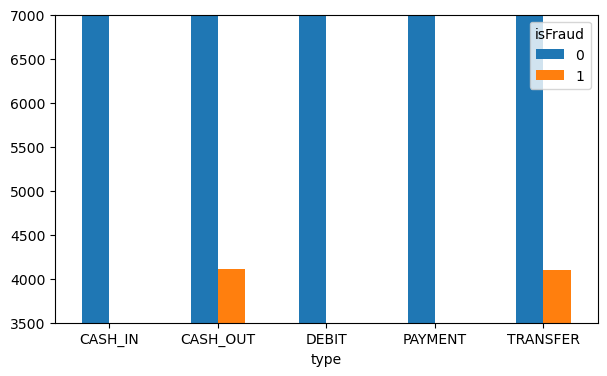

In [ ]:
# Grouped bar chart between TYPE and ISFRAUD by changing ylimit to view isFraud values
CrosstabResult.plot.bar(figsize=(7,4), rot=0)
plt.ylim([3500, 7000])

<AxesSubplot:>

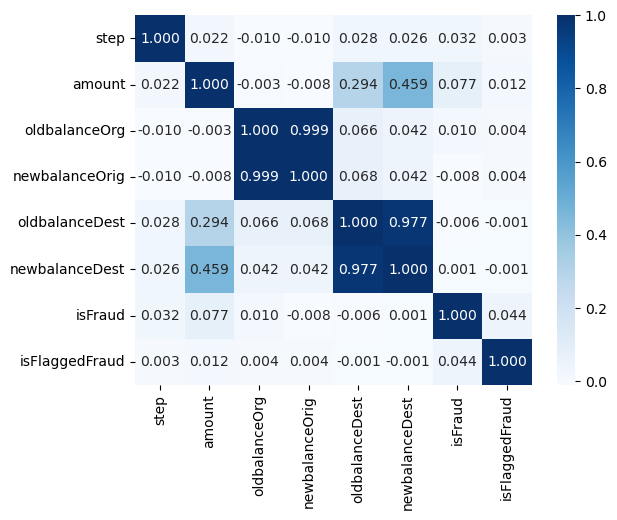

In [ ]:
# calculate correlation matrix
corr = data.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap='Blues' ,fmt=".3f")

In [ ]:
data.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

######Feature engineering

In [ ]:
# Now let’s transform the categorical features into numerical. Here we will also transform the values of the isFraud column into 
# No Fraud and Fraud labels to have a better understanding of the output
# Changing CASH_OUT to 1, PAYMENT to 2, CASH_IN to 3, TRANSFER to 4 and DEBIT to 5 

data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})
data["isFraud"] = data["isFraud"].map({0: "No Fraud", 1: "Fraud"})
print(data.head())

   step  type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1     2   9839.64  C1231006815       170136.0       160296.36   
1     1     2   1864.28  C1666544295        21249.0        19384.72   
2     1     4    181.00  C1305486145          181.0            0.00   
3     1     1    181.00   C840083671          181.0            0.00   
4     1     2  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest   isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0  No Fraud               0  
1  M2044282225             0.0             0.0  No Fraud               0  
2   C553264065             0.0             0.0     Fraud               0  
3    C38997010         21182.0             0.0     Fraud               0  
4  M1230701703             0.0             0.0  No Fraud               0  


In [ ]:
sc = StandardScaler()
data[[ 'amount', 'oldbalanceOrg']] = sc.fit_transform(data[[ 'amount', 'oldbalanceOrg']])
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,-0.281560,C1231006815,-0.229810,160296.36,M1979787155,0.0,0.0,No Fraud,0
1,1,2,-0.294767,C1666544295,-0.281359,19384.72,M2044282225,0.0,0.0,No Fraud,0
2,1,4,-0.297555,C1305486145,-0.288654,0.00,C553264065,0.0,0.0,Fraud,0
3,1,1,-0.297555,C840083671,-0.288654,0.00,C38997010,21182.0,0.0,Fraud,0
4,1,2,-0.278532,C2048537720,-0.274329,29885.86,M1230701703,0.0,0.0,No Fraud,0


In [ ]:
x = np.array(data[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(data[["isFraud"]])

In [ ]:
# training a machine learning model

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)

In [ ]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.999648467664788


In [ ]:
print(model.score(x_train, y_train))

0.9999993264230324


In [ ]:
# prediction
#features = [type, amount, oldbalanceOrg, newbalanceOrig]

features = np.array([[1, 8900.2, 8990.2, 0.0]])
print(model.predict(features))

['Fraud']


In [ ]:
clf = ECOD()

In [ ]:
clf.fit(x_train,y_train)

ECOD(contamination=0.1, n_jobs=1)

In [ ]:
clf.decision_scores_

array([4.80389511, 4.85383793, 8.02520501, ..., 3.66389333, 4.22270045,
       2.79442534])

In [ ]:
clf.fit_predict_score(x_test,y_test,scoring='roc_auc_score')

roc_auc_score: 0.2564674448245162


0.2564674448245162

In [ ]:
clf.fit_predict_score(x_train,y_train)

roc_auc_score: 0.2532088521629633


0.2532088521629633

#The ROC AUC score is 0.2564674448245162, which is relatively low. This means that the classifier has poor performance in distinguishing between positive and negative classes. A score of 0.5 indicates random guessing, while a score of 1 indicates perfect classification.

clf = ECOD(n_jobs=2)
clf.fit(x_train)
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores
y_test_pred = clf.predict(x_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(y_test)  # outlier scores
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)
# visualize the results
visualize(clf_name, x_train, y_train, x_test, y_test, y_train_pred,
y_test_pred, show_figure=True, save_figure=False)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)

In [ ]:
# Create an instance of the KNeighborsClassifier class with k=10
neigh = KNeighborsClassifier(n_neighbors=10)

In [ ]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
X_test = np.array([[1, 8900.2, 8990.2, 0.0]])

In [ ]:
y_pred = neigh.predict(X_test)

In [ ]:
print(y_pred)

['No Fraud']


In [ ]:
models = {
    "LR": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    }

In [ ]:
for name, model in models.items():
    print(f'Training Model {name} \n--------------')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'Training Accuracy: {accuracy_score(y_train, model.predict(X_train))}')
    print(f'Testing Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print("Recall Score : ",recall_score(y_test, y_pred, pos_label='positive', average='micro'))    
    print("Precision Score : ",precision_score(y_test, y_pred,  pos_label='positive',average='micro'))     
    print(f"Testing F-1:", f1_score(y_test, y_pred, pos_label='positive', average='micro' )        )
    print('-'*30)

Training Model LR 
--------------
Training Accuracy: 0.9987096510556972
Testing Confusion Matrix: 
[[      0    2468]
 [      1 1906317]]
Recall Score :  0.9987065076965149
Precision Score :  0.9987065076965149
Testing F-1: 0.9987065076965149
------------------------------
Training Model KNN 
--------------
Training Accuracy: 0.9997359578286932
Testing Confusion Matrix: 
[[   2052     416]
 [    395 1905923]]
Recall Score :  0.9995751226172027
Precision Score :  0.9995751226172027
Testing F-1: 0.9995751226172027
------------------------------
Training Model DT 
--------------
Training Accuracy: 0.9999993264230324
Testing Confusion Matrix: 
[[   2125     343]
 [    314 1906004]]
Recall Score :  0.9996558021695465
Precision Score :  0.9996558021695465
Testing F-1: 0.9996558021695465
------------------------------
Training Model RF 
--------------
Training Accuracy: 0.9999991018973765
Testing Confusion Matrix: 
[[   2169     299]
 [    254 1906064]]
Recall Score :  0.9997102870620383
Prec